In [119]:
import dnnlib
import legacy
import torch
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import scipy.interpolate
import math
import random
from tqdm import tqdm
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
network_pkl = "../t-golden-fid14.19.pkl"
print('Loading networks from "%s"...' % network_pkl)
device = torch.device('cuda')
with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore
print("Network loaded.")

Loading networks from "../t-golden-fid14.19.pkl"...
Network loaded.


In [125]:
def find_largest_bbox(self, img, bbox):
    img_height, img_width, _channels = img.shape
    x, y, w, h = bbox
    diff = w - h
    if diff > 0:
        y = y - diff // 2
        h = w
    elif diff < 0:
        x = x + diff // 2
        w = h
    if w != h:
        print("BBOX IS NOT SQUARE!")
        return None

    dx = x
    dy = y
    dw = img_width - (x + w)
    dh = img_height - (y + h)
    pad = 40
    if dx <= pad or dy <= pad or dh <= pad or dw <= pad:
        print("BBOX TOO CLOSE TO EDGE")
        return None

    offset = min(dx, dy, dw, dh)
    return (x - offset, y - offset, w + 2 * offset, h + 2 * offset)

def crop_to_largest_bbox(self, file):
    img = itools.read_file(file)
    contrast = itools.contrast(img, self.contval)
    sat = itools.saturate(contrast, self.satval)
    gray = itools.threshold(sat, self.thresh)
    contour = itools.find_largest_contour(gray)

    if contour is None:
        raise "NO CONTOUR"

    # get the bounding box
    bbox = cv2.boundingRect(contour)

    # delete if there is no bounding box
    if bbox is None:
        raise "NO BBOX FOUND"

    crop = self.find_largest_bbox(img, bbox)
    if crop is None:
        raise "NO CROP FOUND"

    cropped = itools.crop(img, crop)
    return cropped

torch.Size([1, 3, 1024, 1024])


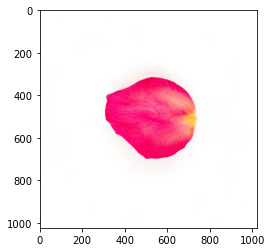

In [118]:
def make_transform(translate, angle):
    m = np.eye(3)
    s = np.sin(angle/360.0*np.pi*2)
    c = np.cos(angle/360.0*np.pi*2)
    m[0][0] = c
    m[0][1] = s
    m[0][2] = translate[0]
    m[1][0] = -s
    m[1][1] = c
    m[1][2] = translate[1]
    return m

def synthesize_image(z, translate=(0,0), rotate=0, noise_mode = "const", truncation_psi = 1):
    label = torch.zeros([1, G.c_dim], device=device)
    # Construct an inverse rotation/translation matrix and pass to the generator.  The
    # generator expects this matrix as an inverse to avoid potentially failing numerical
    # operations in the network.
    if hasattr(G.synthesis, 'input'):
        m = make_transform(translate, rotate)
        m = np.linalg.inv(m)
        G.synthesis.input.transform.copy_(torch.from_numpy(m))

    img = G(z, label, truncation_psi=truncation_psi, noise_mode=noise_mode)
    print(img.shape)
    img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
    return PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')
#     PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB').save(f'{outdir}/seed{seed:04d}.png')

def synthesize_rand_image(seed):
    z = torch.from_numpy(np.random.RandomState(seed).randn(1, G.z_dim)).to(device)
    return synthesize_image(z)

# 9 
# 13
# 16
# 20
# 21
# 25
# 27
# 28
# 31
# 34
# 37
# 38
# 39
# 43
# 49
# 50
# 400
img = synthesize_rand_image(50)
plt.imshow(img)

In [26]:
z = torch.from_numpy(np.random.RandomState(1).randn(G.z_dim)).to(device)
print("z.shape, G.z_dim", z.shape, G.z_dim)


# testing
a = np.array([[1, 2, 3], [4, 5, 6]])
t = np.tile(a, [2])
print("a.shape, t.shape", a.shape, t.shape)

z.shape, G.z_dim torch.Size([512]) 512
a.shape, t.shape (2, 3) (2, 6)


In [74]:
def synthesize_rand_interp(seeds, w_frames = 20):
    print("interpolating: ", seeds)
#     num_keyframes = 100
    num_keyframes = len(seeds) // 1
    wraps = 1
    kind= "cubic"
    imgs = []
#     w_frames=60*4
    
    zs = torch.from_numpy(np.stack([np.random.RandomState(seed).randn(G.z_dim) for seed in seeds])).to(device)
    ws = G.mapping(z=zs, c=None, truncation_psi=1)
    _ = G.synthesis(ws[:1]) # warm up
    print("ws.shape original", ws.shape)
    print("ws[:1].shape", ws.shape[:1])
    ws = ws.reshape(1, 1, num_keyframes, *ws.shape[1:])
    print("ws.shape", ws.shape)
    
    # wraps = 0
    # ws.shape torch.Size([1, 1, 2, 16, 512])
    # x.shape, y.shape (2,) (2, 16, 512)
    
    # wrapping back to the original
#     x = np.arange(-num_keyframes * wraps, num_keyframes * (wraps + 1))
#     y = np.tile(ws[0][0].cpu().numpy(), [wraps * 2 + 1, 1, 1])
    
    x = np.arange(-num_keyframes * wraps, num_keyframes * (wraps + 1))
    y = np.tile(ws[0][0].cpu().numpy(), [wraps * 2 + 1, 1, 1])

#     x = np.arange(0, 2)
#     y = np.tile(ws[0][0].cpu().numpy(), [1, 1, 1])
    print("x.shape, y.shape", x.shape, y.shape)
    interp = scipy.interpolate.interp1d(x, y, kind=kind, axis=0)
    
    for frame_idx in tqdm(range(num_keyframes * w_frames)):
        w = torch.from_numpy(interp(frame_idx / w_frames)).to(device)
        img = G.synthesis(ws=w.unsqueeze(0), noise_mode='const')[0]
        img = img.reshape(1, 3, 1024, 1024)
        img = (img * 127.5 + 128).clamp(0, 255).to(torch.uint8)
#         img = (img.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
        img = img.permute(0, 2, 3, 1)
        img = PIL.Image.fromarray(img[0].cpu().numpy(), 'RGB')
        imgs.append(img)
    
    return imgs
    
imgs = synthesize_rand_interp([9, 300, 400, 500])

interpolating:  [200, 300, 400, 500]
ws.shape original torch.Size([4, 16, 512])
ws[:1].shape torch.Size([4])
ws.shape torch.Size([1, 1, 4, 16, 512])
x.shape, y.shape (4,) (4, 16, 512)


100%|████████████████████████████████████████████████████████████████████████████████████████████████| 80/80 [00:48<00:00,  1.65it/s]


images 80


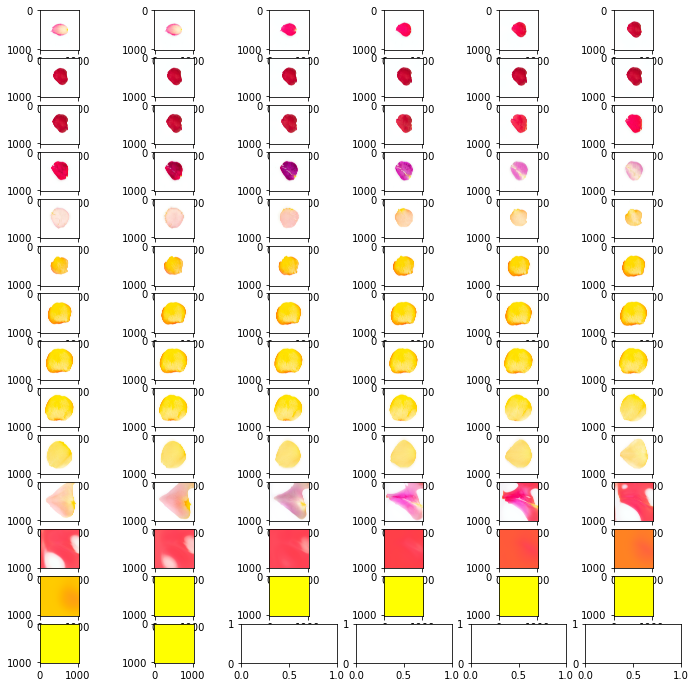

In [124]:
# plt.imshow(imgs[2])
# # plt.imshow(imgs[1])
print("images", len(imgs))
cols = min(len(imgs), 6)
rows = max(math.ceil(len(imgs) / cols), 1)
_, axs = plt.subplots(rows, cols, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

In [122]:
def synthesize_kaleidascope(num_seeds = 4, w_frames = 20):
    seeds = [random.randint(1, 10000) for i in range(num_seeds)]
    print(seeds)
    
    cropped_imgs = []
    for 

synthesize_kaleidascope()

[3421, 807, 5350, 1836]
